# Flag Median and FlagIRLS

These are the examples for The Flag Median and FlagIRLS 2021 CVPR submission.

In [1]:
import numpy as np
import center_algorithms as ca
import matplotlib.pyplot as plt
import torch
import pandas
import seaborn as sns
from sklearn.manifold import MDS
import time

In [2]:
'''
This function verifies that we found a local optimizer for
the sine median or maximum cosine problem.
It does this by checking 100 points around the optimizer.

Inputs: 
    optimizer- a numpy array that represente the suggested optimizer
    opf_fn- a string, 'sine' for sine median and 'cosine' for maximum cosine
    data- a list of numpy arrays representing points on grassmannians
Outputs:
    local optimizer- True if all checked points rsesult in objective function values
                        that are greater than the Sine Median problem or smaller than
                        the Maximum Cosine value
'''
def sanity_check(optimizer, opt_fn, data):
    
    n,r = optimizer.shape
    
    
    #objective function value for suggested optimizer
    sln_val = ca.calc_error_1_2(data, optimizer, opt_fn) 
    
    #stays true if optimizer is a local min
    local_optimizer = True

    #checking random points
    perturb_vals = []
    for i in range(100):
        
        #random points between -.5 and .5 times .01
        perturb = (np.random.rand(n,r)-5)*.00001 
        perturb_check = np.linalg.qr(perturb + optimizer)[0][:,:r]
        
        #check objective function value
        perturb_vals.append(ca.calc_error_1_2(data, perturb_check, opt_fn))

        if opt_fn == 'sine' or opt_fn == 'l2_med':
            if perturb_vals[i] < sln_val:
                local_optimizer = False
                print('Algorithm did not converge to minimizer')

    if not local_optimizer:
        print(sln_val)
        print(perturb_vals)
    return local_optimizer

def calc_chordal_dist(X, Y, r):
    sum_sin = r- np.trace(X.T @ Y @ Y.T @ X)
    if sum_sin < 0:
        sum_sin = 0
    return np.sqrt(sum_sin)

    

## Convergence Example

In [3]:
k1=3 #Gr(k1,n)
k2=5 #Gr(k2,n)
r=3
n=20
n_its = 100 #number of iterations for FlagIRLS
seed = 1 #random seed
num_points = 20 #number of points in dataset
n_trials = 100 #number of trials for sanity check

#generate dataset of points in Gr(ki,n)
#half the points are in Gr(k1,n) and the second half are in Gr(k2,n)

np.random.seed(0)

gr_list = []
for i in range(1 + num_points//2):
    Y_raw = np.random.rand(n,k1)-.5
    Y = np.linalg.qr(Y_raw)[0][:,:k1]
    gr_list.append(Y)
for i in range(num_points//2):
    Y_raw = np.random.rand(n,k2)-.5
    Y = np.linalg.qr(Y_raw)[0][:,:k2]
    gr_list.append(Y)


### Verify Convergence

In [4]:
n_corrects = 0

for seed in range(1,n_trials+1):
    flag_median = ca.irls_flag(gr_list, r, n_its, 'sine', opt_err = 'sine', seed = 0)[0]
    
    
    if sanity_check(flag_median, 'sine', gr_list):
        n_corrects += 1        


print(str(100* (n_corrects/n_trials))+' percent of trials that resulted in local optimizers')

100.0 percent of trials that resulted in local optimizers


### Comparison to Gradient Descent

Text(0, 0.5, 'Objective Function Value')

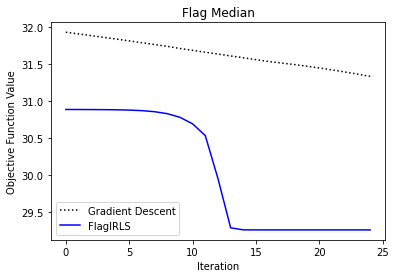

In [5]:
flg_errs = []
gd_errs = []
for seed in range(100):
    flg_errs.append(np.array(ca.irls_flag(gr_list, r, n_its, 'sine', opt_err = 'sine', seed = 0)[1]))
    gd_errs.append(np.array(ca.gradient_descent(gr_list, r, -.01, n_its, 'sine', seed = 0)[1]))

flg_err = np.mean(np.vstack(flg_errs), axis = 0)
gd_err = np.mean(np.vstack(gd_errs), axis = 0)

plt.figure()
plt.plot(gd_err[:len(flg_err)], label = 'Gradient Descent', color = 'black', linestyle = 'dotted')
plt.plot(flg_err, label = 'FlagIRLS', color = 'blue', linestyle = 'solid')
plt.title('Flag Median')
plt.legend()
# plt.xticks([n for n in range(0,21,5)])
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

## FlagIRLS vs Weiszfeld

In [6]:
k=6 #Gr(k1,n)
r=6
n=100
n_its = 1000 #number of iterationss
n_trials = 20


num_points = 200 #number of points in dataset
n_trials = 20 #number of trials for sanity check

len_flag_med_errs = []
len_l2_errs_data = []
len_l2_errs_rand = []

flag_med_time = []
l2_errs_data_time = []
l2_errs_rand_time = []
for seed in range(n_trials):

    np.random.seed(0)

    center = np.random.rand(n,k)*10
    center_rep = np.linalg.qr(center)[0][:,:k]

    diameter = 10**(-2)
    #generate dataset of points in Gr(k,n)
    gr_list = []
    for i in range(num_points):
        Y_raw = center_rep + (np.random.rand(n,k)-.5)*diameter
        Y = np.linalg.qr(Y_raw)[0][:,:k]
        gr_list.append(Y)


    #calculate sine median
    start = time.time()
    sine_median_error = ca.irls_flag(gr_list, r, n_its-1, 'sine', opt_err = 'sine', seed = seed)[1]
    flag_med_time.append(time.time()-start)
    len_flag_med_errs.append(len(sine_median_error))

    #calc l2 median
    start = time.time()
    l2_errs_data = ca.l2_median(gr_list, .1, r, n_its, seed, True)[1]
    l2_errs_data_time.append(time.time()-start)
    len_l2_errs_data.append(len(l2_errs_data))

    #calc l2 median
    start = time.time()
    l2_errs_rand = ca.l2_median(gr_list, .1, r, n_its, seed, False)[1]
    l2_errs_rand_time.append(time.time()-start)
    len_l2_errs_rand.append(len(l2_errs_rand))


print('average number of its to converge')
print('flag median: '+str(np.mean(len_flag_med_errs))+' +/-'+str(np.std(len_flag_med_errs)))
print('l2 median: (init datapoint) '+str(np.mean(len_l2_errs_data))+' +/-'+str(np.std(len_l2_errs_data)))
print('l2 median: (init same as flag median) '+str(np.mean(len_l2_errs_rand))+' +/-'+str(np.std(len_l2_errs_rand)))


print('average times to convergence')
print('flag median: '+str(np.mean(flag_med_time))+' +/-'+str(np.std(flag_med_time)))
print('l2 median: (init datapoint) '+str(np.mean(l2_errs_data_time))+' +/-'+str(np.std(l2_errs_data_time)))
print('l2 median: (init same as flag median) '+str(np.mean(l2_errs_rand_time))+' +/-'+str(np.std(l2_errs_rand_time)))

converged to datapoint
converged to datapoint
converged to datapoint
converged to datapoint
converged to datapoint
converged to datapoint
converged to datapoint
converged to datapoint
converged to datapoint
converged to datapoint
converged to datapoint
converged to datapoint
converged to datapoint
converged to datapoint
converged to datapoint
converged to datapoint
converged to datapoint
converged to datapoint
converged to datapoint
converged to datapoint
average number of its to converge
flag median: 4.4 +/-0.4898979485566356
l2 median: (init datapoint) 801.55 +/-231.70141885625128
l2 median: (init same as flag median) 954.1 +/-134.9751458602657
average times to convergence
flag median: 0.1297934889793396 +/-0.01786669822408328
l2 median: (init datapoint) 21.663724958896637 +/-6.142836560629436
l2 median: (init same as flag median) 25.454519319534302 +/-3.646501020585479


## Cluster with Outliers

Flag Mean finished
Sine Median finished
L2 median finished
sine median converged correctly
l2 median converged correctly
flag mean chordal dist is: 0.0128494446016294
sine median chordal dist is: 0.001715488326324446
l2 median chordal dist is: 0.0022241550979146965


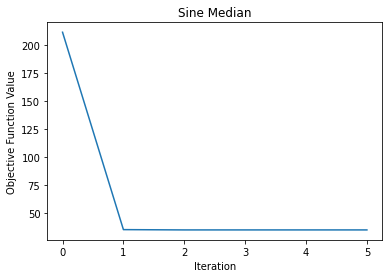

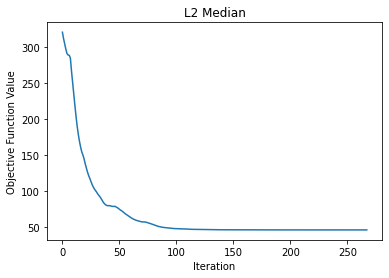

In [6]:
k=3 #Gr(k1,n)
r=3
n=20
n_its = 20 #number of iterations for FlagIRLS
seed = 1 #random seed
num_points = 200 #number of points in dataset
n_trials = 100 #number of trials for sanity check

np.random.seed(seed)

center = np.random.rand(n,k)*10
center_rep = np.linalg.qr(center)[0][:,:k]

#generate dataset of points in Gr(k,n)
gr_list = []
for i in range(num_points- np.int(num_points*.10)):
    Y_raw = center_rep + (np.random.rand(n,k)-.5)*.01
    Y = np.linalg.qr(Y_raw)[0][:,:k]
    gr_list.append(Y)
    
for i in range(np.int(num_points*.10)):
    Y_raw = np.random.rand(n,k)-.5
    Y = np.linalg.qr(Y_raw)[0][:,:k]
    gr_list.append(Y)
    

#calculate flag mean
flag_mean = ca.flag_mean(gr_list, r)
print('Flag Mean finished')

#calculate sine median
sin_median, s_err = ca.irls_flag(gr_list, r, n_its, 'sine', opt_err = 'sine', seed = seed)
print('Sine Median finished')

#calculate l2 median
l2_med, l2_err = ca.l2_median(gr_list, .1, r, 1000, seed)
print('L2 median finished')
    
if sanity_check(sin_median, 'sine', gr_list):
    print('sine median converged correctly')      
if sanity_check(l2_med, 'l2_med', gr_list):
    print('l2 median converged correctly') 
    
plt.figure()
plt.plot(s_err)
plt.title('Sine Median')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')


plt.figure()
plt.plot(l2_err)
plt.title('L2 Median')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

    
print('flag mean chordal dist is: ' +str(calc_chordal_dist(center_rep, flag_mean, r)))

print('sine median chordal dist is: ' +str(calc_chordal_dist(center_rep, sin_median, r)))

print('l2 median chordal dist is: ' +str(calc_chordal_dist(center_rep, l2_med, r)))




## MNIST Examples

In [3]:


def load_mnist_data(digits, sample_size=100, dset='train', shuffle = False, data_path = './data/MNIST/'):
    '''
    Shannon Stiverson's dataloader

    Inputs:
        digits- list or int for digits from MNIST to be samples
        sample_size - number of samples of that digit
        dset - 'train' or 'test' for sampling from the training or the test datasets
    Outputs:
        out_datamat - a numpy array of dimensions (784 x sample_size)
        datamat_labels - a list of labels of the sampled points
    '''

    if type(digits) == int:
        digits = [digits]

    if type(sample_size) == int:
        sample_size = [sample_size]*len(digits)

    if len(sample_size) != len(digits):
        print('Incorrect number of sample sizes given.')
        return [], []

    return_data = []
    return_labels = []

    for i in range(len(digits)):
        digit = digits[i]
        size = sample_size[i]
        digit_data = np.loadtxt(data_path+'%s%i.csv' % (dset, digit), delimiter=',')
        if digit_data.shape[1] < size:
            print('Sample number for digit %i reduced to %i' % (digit, digit_data.shape[1]))
            return_data.append(digit_data)
            return_labels.append([digit]*digit_data.shape[1])
        else:
            if shuffle:
                idx = np.random.choice(np.arange(digit_data.shape[1]), size)
            else:
                idx = np.arange(size)
            return_data.append(digit_data[idx, :])
            return_labels.append([digit]*size)

    datamat = return_data[0]
    datamat_labels = return_labels[0]

    if len(digits) > 1:
        for i in range(1, len(digits)):
            datamat = np.vstack((datamat, return_data[i]))
            datamat_labels = np.hstack((datamat_labels, return_labels[i]))

    out_datamat = datamat.T
    
    return out_datamat, datamat_labels

'''
This function verifies that we found a local optimizer for
the sine median or maximum cosine problem.
It does this by checking 100 points around the optimizer.

Inputs: 
    optimizer- a numpy array that represente the suggested optimizer
    opf_fn- a string, 'sine' for sine median and 'cosine' for maximum cosine
    data- a list of numpy arrays representing points on grassmannians
Outputs:
    local optimizer- True if all checked points rsesult in objective function values
                        that are greater than the Sine Median problem or smaller than
                        the Maximum Cosine value
'''
def mnist_sanity_check(optimizer, opt_fn, data):
    
    n,r = optimizer.shape
    
    
    #objective function value for suggested optimizer
    sln_val = ca.calc_error_1_2(data, optimizer, opt_fn) 
    
    #stays true if optimizer is a local min
    local_optimizer = True

    #checking random points
    perturb_vals = []
    for i in range(100):
        
        #random points between -.5 and .5 times .01
        perturb = (np.random.rand(n,r)-5)*.00001 
        perturb_check = np.linalg.qr(perturb + optimizer)[0][:,:r]
        
        #check objective function value
        perturb_vals.append(ca.calc_error_1_2(data, perturb_check, opt_fn))

        if opt_fn == 'sine' or opt_fn == 'l2_med':
            if perturb_vals[i] < sln_val:
                local_optimizer = False
#                 print(perturb_vals[i])
#                 print(sln_val)
#                 print('FlagIRLS did not converge to minimizer')
        elif opt_fn == 'cosine':
            if perturb_vals[i] > sln_val:
                local_optimizer = False
#                 print(perturb_vals[i])
#                 print(sln_val)
#                 print('FlagIRLS did not converge to maximizer')

    # if not local_optimizer:
    #     print(sln_val)
    #     print(perturb_vals)
    return local_optimizer


def run_mnist_test(k, digit1, digit2, num_samples1, num_samples2,n_its,seed):
    '''
    calculates Flag Mean, Maximum Cosine and Sine Median for a dataset

    Inputs:
        k- int for Gr(k,784)
        digit1- int for first digit
        digit2- int for second digit
        num_samples1- int for number of samples of digit1s
        num_samples2- int for number of samples of digit2s
        n_its- integer for the number of iterations of FlagIRLS
        seed- int for numpy random initialization
    Outputs:
        flagmean- numpy array that represents Flag Mean of gr_list
        sin_median- numpy array that represents Sine Median of gr_list
        max_cosine- numpy array that represents Max Cosine of gr_list
        gr_list- dataset as subspaces in Gr(k,748)
    '''
    
    data_matrix1 = load_mnist_data(digit1, k*num_samples1, dset='train')[0]
    data_matrix2 = load_mnist_data(digit2, k*num_samples2, dset='train')[0]

    gr_list = []
    for i in range(num_samples1):
        #TODO: make sure we're taking more than one two
        if k==1:
            point = data_matrix1[:,i*k:(i+1)*k]
            gr_list.append(point/np.linalg.norm(point))
        else:
            point = data_matrix1[:,i*k:(i+1)*k]
            gr_list.append(np.linalg.qr(point)[0][:,:k])

    for i in range(num_samples2):
        if k==1:
            point = data_matrix2[:,i*k:(i+1)*k]
            gr_list.append(point/np.linalg.norm(point))
        else:
            point = data_matrix2[:,i*k:(i+1)*k]
            gr_list.append(np.linalg.qr(point)[0][:,:k])
            
    
    flagmean = ca.flag_mean(gr_list, k)
    # print('Flag Mean finished')

    #calculate sine median
    sin_median = ca.irls_flag(gr_list, k, n_its, 'sine', opt_err = 'sine', seed = seed)[0]
    # print('Chordal Median finished')

    
    #calculate l2 median
    #do it more than once if needed
    worked = False
    l2_seed = seed
    while not worked:
        l2_med = ca.l2_median(gr_list, .1, k, 1000, l2_seed)[0]
        worked = mnist_sanity_check(l2_med, 'l2_med', gr_list)
        # print('l2 trial')
        l2_seed+=1
        
    # print('L2 median finished')
    
    return flagmean, sin_median, l2_med, gr_list



## MNIST Nerual Network

In [4]:
k = 1 #Gr(k,n)
digit1 = 1
digit2 = 9
num_samples1 = 20 #number of samples of the 2 digit
n_its = 20 #number of iterations for FlagIRLS
seed = 1 #for initialization
incr = 1 #samples 5s from 0 to num_samples2 in increments of incr

plot_k = 0 #the ith column of the outputs of FlagIRLS and FlagIRLS

model_path = './models/'

In [5]:
model = torch.load(model_path+'model49.pth')

model.eval()

predictions = pandas.DataFrame(columns = ['Prototype', 'Added Nines', 'Prediction'])

if num_samples1 % incr != 0:
    print('incr does not divide num_samples2 evenly!')
else:
    flagmeans = []
    flag_medians = []
    l2_meds = []
    n2s  = []
    n5s = []

    for num_samples2 in range(0,num_samples1,incr):
        out = run_mnist_test(k,digit1,digit2,num_samples1,num_samples2,n_its,seed)
        flagmeans.append(out[0])
        flag_medians.append(out[1])
        l2_meds.append(out[2])
        n2s.append(num_samples1)
        n5s.append(num_samples2)
        dataset = out[3]
        
    # model = torch.load('../MNIST_Classifier/raw_triangle_nn_3layer_lr_p1/model/model49.pth')
    

    for i in range(20):
        point = flag_medians[i]
        s_prediction = torch.argmax(model(torch.tensor(point.T*-255).float())).item()

        point = flagmeans[i]
        f_prediction = torch.argmax(model(torch.tensor(point.T*-255).float())).item()
        
        point = l2_meds[i]
        l_prediction = torch.argmax(model(torch.tensor(point.T*-255).float())).item()
        
        predictions = predictions.append({'Prototype': 'Flag Median',
                                        'Added Nines': i,
                                        'Prediction': s_prediction}, ignore_index = True)

        predictions = predictions.append({'Prototype': 'L2 Median',
                                        'Added Nines': i,
                                        'Prediction': l_prediction}, ignore_index = True)
        
        predictions = predictions.append({'Prototype': 'Flag Mean',
                                        'Added Nines': i,
                                        'Prediction': f_prediction}, ignore_index = True)

    print('trial '+str(seed)+' done')
    


/home/katrina/a/mankovic/anaconda3/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/katrina/a/mankovic/anaconda3/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.flatten.Flatten' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/katrina/a/mankovic/anaconda3/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve t

TypeError: flag_mean() got an unexpected keyword argument 'fast'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Prediction')

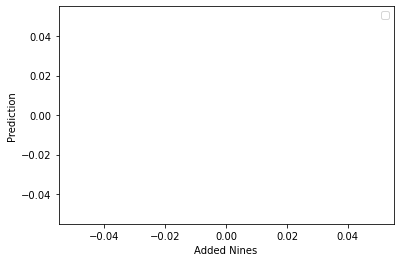

In [6]:

linestyles = ['solid', 'dashdot', 'dotted']
markers = ['o', '>', 'x']
j=0
ci = 0
for alg in ['Flag Median', 'L2 Median', 'Flag Mean']:
    small = predictions[predictions['Prototype'] == alg][['Added Nines', 'Prediction']]
    x = []
    for i in range(20):
        temp = np.array(small[small['Added Nines'] == i]['Prediction'])
        x.append(temp)

    plt.plot(np.arange(20), x, label = alg, linestyle = linestyles[j], marker = markers[j])

    j+=1
plt.legend()
plt.xlabel('Added Nines')
plt.ylabel('Prediction')


## MNIST MDS

In [31]:
def run_embedding_test(k, include_data = True):
    '''
    plots MDS embedding of exemplars and datasets with 20 examples of 7s and 0,1,2,...,19 examples of 6s
    
    Inputs: 
        k (integer) points on Gr(k,n)
    '''
    num_samples1 = 20 #number of samples of the 6 digit
    n_its = 20 #number of iterations for FlagIRLS
    seed = 1 #for initialization
    incr = 1 #samples 5s from 0 to num_samples2 in increments of incr
    # plot_k = 0 #the ith column of the outputs of FlagIRLS and FlagIRLS
    digit1 = 6
    digit2 = 7

    if num_samples1 % incr != 0:
        print('incr does not divide num_samples2 evenly!')
        
    
    flagmeans = []
    flag_medians = []
    l2_meds = []
    n2s  = []
    n5s = []

    for num_samples2 in range(0,num_samples1,incr):
        out = run_mnist_test(k,digit1,digit2,num_samples1,num_samples2,n_its,seed)
        flagmeans.append(out[0])
        flag_medians.append(out[1])
        l2_meds.append(out[2])
        n2s.append(num_samples1)
        n5s.append(num_samples2)
        dataset = out[3]

    dataset_and_averages = dataset + flag_medians+l2_meds+flagmeans

    n_all_pts = len(dataset_and_averages)

    Distances = np.zeros((n_all_pts, n_all_pts))

    for i in range(n_all_pts):
        for j in range(i+1, n_all_pts):
            if k == 1:
                cos = (dataset_and_averages[i].T @ dataset_and_averages[j] @ dataset_and_averages[j].T @ dataset_and_averages[i])[0][0]
                if cos > 1:
                    cos = 1
                elif cos < 0:
                    cos = 0
                Distances[i,j] = np.arccos(np.sqrt(cos))
                Distances[j,i] = Distances[i,j].copy()
            else:
                cos = np.linalg.svd(dataset_and_averages[i].T @ dataset_and_averages[j])[1]
                sumcos = np.sum(np.arccos(cos)**2)
                if np.isnan(sumcos):
                    print(cos)
                    sumcos = 0
                Distances[i,j] = np.sqrt(sumcos)
    #             Distances[i,j] = k - np.trace(dataset_and_averages[i].T @ dataset_and_averages[j] @ dataset_and_averages[j].T @ dataset_and_averages[i])
                Distances[j,i] = Distances[i,j].copy()

    embedding = MDS(dissimilarity = 'precomputed', n_components = 2)
    transformed = embedding.fit_transform(Distances)

    for i in range(0,num_samples2+1,4):
        plt.figure()
        if include_data:
            plt.scatter(transformed[:num_samples1,0], transformed[:num_samples1,1], c = '.2', label = 'Sevens')
            if i > 0:
                plt.scatter(transformed[num_samples1:num_samples1+i,0], transformed[num_samples1:num_samples1+i,1], color = 'purple', marker = 'x', label = 'Sixes')
        plt.plot(transformed[num_samples1+num_samples2:num_samples1+num_samples2+i+1,0], transformed[num_samples1+num_samples2:num_samples1+num_samples2+i+1,1], c = 'blue', fillstyle = 'none', marker = '>', markevery = 4, label = 'Flag Median')
        plt.plot(transformed[num_samples1+(num_samples2+1)*2-1:num_samples1+(num_samples2+1)*2-1+i+1,0], transformed[num_samples1+(num_samples2+1)*2-1:num_samples1+(num_samples2+1)*2-1+i+1,1], c = 'orange', linestyle = 'dashdot', fillstyle = 'none', marker = '>', markevery = 4, label = 'L2 Median')
        plt.plot(transformed[num_samples1+(num_samples2+1)*3-1:num_samples1+(num_samples2+1)*3-1+i+1,0], transformed[num_samples1+(num_samples2+1)*3-1:num_samples1+(num_samples2+1)*3-1+i+1,1], c = 'green', linestyle = 'dotted', fillstyle = 'none', marker = '>', markevery = 4, label = 'Flag Mean')
        if i == 8:
            plt.legend()
            plt.xlabel('MDS 1')
            plt.ylabel('MDS 2')

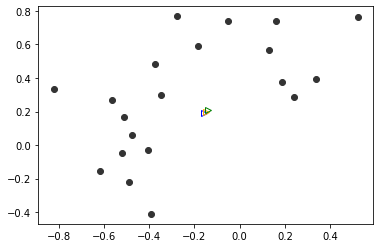

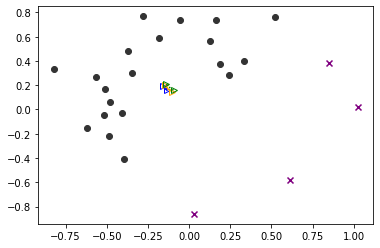

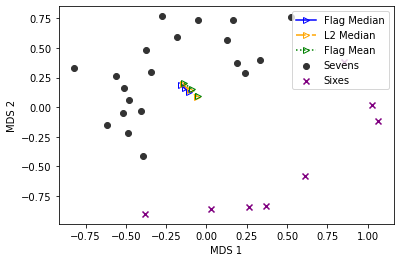

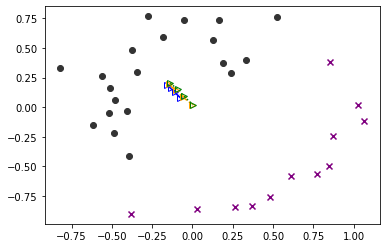

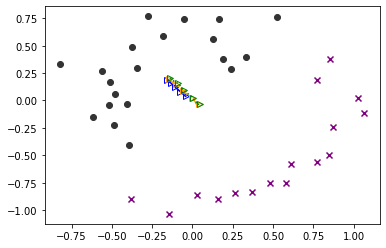

In [32]:
run_embedding_test(1)

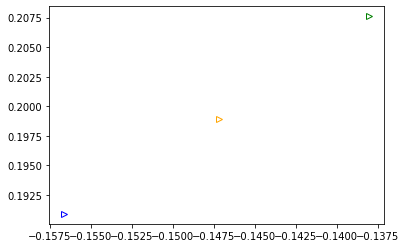

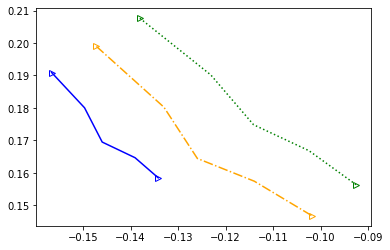

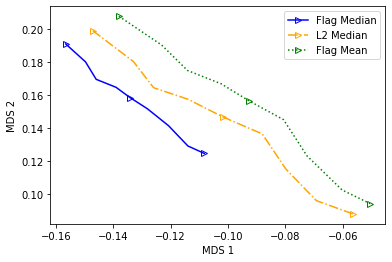

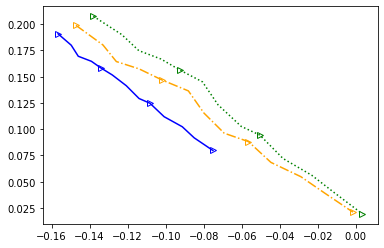

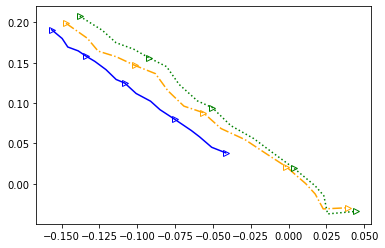

In [33]:
run_embedding_test(1, False)

# Minds Eye

In [7]:
#using dataset from Marrinan et al. 
#see https://www.cs.colostate.edu/~vision/summet/
%run run_lbg_minds_eye

cluster 4 trial 0
.
.
.
sin start


KeyboardInterrupt: 

# UCF YouTube Action

In [ ]:
#generate data on grassmannian
#data downloaded from https://www.crcv.ucf.edu/data/UCF_YouTube_Action.php 
#UCF YouTube Action Dataset
%run youtube_dataset

In [8]:
#run LBG
%run youtube_lbg

cluster 4 trial 0
.
.
.
sin start


KeyboardInterrupt: 